In [367]:
!python driver.py --lamb 2e1 --alpha 1 --backward 1 --nu 1e0 --steps 10 --steps_back 10 --bottleneck 2 --eta 1e1 --dataset pendulum --theta 2.4 --epochs 100 --batch 64 --folder results_pendulum --lr_update 300 400 450 500 --lr_decay 0.2 --print_every 20 --lr 1e-2 --lags 1 --plot_latent 0

Using the CPU
Data loaded
Dataloader created
torch.Size([2178, 1, 2, 1])
koopmanAE created
**** Setup ****
Total params: 0.00M
Total params: 0.72k
************
koopmanAE(
  (encoder): encoderNet(
    (tanh): Tanh()
    (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=2, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): decoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=2, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=2, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=2, out_features=2, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=2, out_features=2, bias=False)
  )
)
Using the CPU
********** Epoch 1 **********
loss identity (actual):  0.00

We need:

identity <<0.2

consist small

backward/forward <2.4

In [253]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init
import sys

sys.path.append('../src')
from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
steps = 0
lags = 1
b =2
#******************************************************************************
# load data
#******************************************************************************
X, Xclean, m, n = data_from_name("pendulum",theta=2.4)

#******************************************************************************
# Reshape data for pytorch into 4D tensor Samples x Channels x Width x Height
#******************************************************************************
Xclean_u =Xclean
Xclean = add_channels(Xclean)

# transfer to tensor
Xclean = torch.from_numpy(Xclean).float().contiguous()


print(Xclean.shape)

#******************************************************************************
# Create Dataloader objects
#******************************************************************************
trainDat = []
start = 0
for i in np.arange(steps,-1, -1):
    if i == 0:
        trainDat.append(Xclean[start:])
    else:
        trainDat.append(Xclean[start:-i])
    start += 1

train_data = torch.utils.data.TensorDataset(*trainDat)
del(trainDat)

# train_loader = DataLoader(dataset = train_data,
#                               batch_size = 64,
#                               shuffle = True)

torch.Size([2200, 1, 2, 1])


In [30]:
Xclean.shape

torch.Size([2200, 1, 2, 1])

In [44]:
Xclean_u.shape

(2200, 2)

In [358]:
model_path = "results_pendulum/model_backward0.pkl"
# m, n, b, steps, steps_back =
model = koopmanAE(m, n, lags, b, steps=60, steps_back=0, alpha=2)
model.load_state_dict(torch.load(model_path))
model.eval()

koopmanAE(
  (encoder): encoderNet(
    (tanh): Tanh()
    (batch1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): decoderNet(
    (tanh): Tanh()
    (fc1): Linear(in_features=2, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=2, bias=True)
  )
  (dynamics): dynamics(
    (dynamics): Linear(in_features=2, out_features=2, bias=False)
  )
  (backdynamics): dynamics_back(
    (dynamics): Linear(in_features=2, out_features=2, bias=False)
  )
)

In [32]:
train_data[:][0].shape

torch.Size([2200, 1, 2, 1])

In [359]:
with torch.no_grad():
    embedding= (model.encoder(train_data[:][0]))

embedding = np.reshape(embedding, newshape= (-1,b))

In [360]:
A =  model.dynamics.dynamics.weight.cpu().data.numpy()
w, v = np.linalg.eig(A)
print(np.abs(w))

projected = np.dot(embedding,v)

[0.9900003  0.99000007]


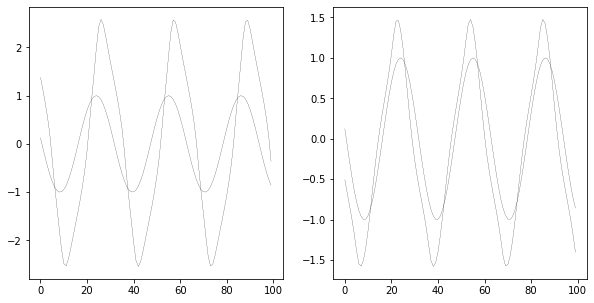

In [363]:
to_plot= projected[:100]

fig, ax = plt.subplots(nrows=int(b/2), ncols=2, figsize=(b*5,5))
for i in range(b):
#     print(i%3, int(i/4))
    ax[i%2].plot(to_plot[:,i], 'k', linewidth=.2)
    # ax[i%2].plot(6.3*np.sin(10+0.2*np.linspace(0,100,num=100)), 'k', linewidth=.2)
    ax[i%2].plot(1*np.sin(9.3+0.2*np.linspace(0,100,num=100)), 'k', linewidth=.2)

[1.0123888 0.9884834]


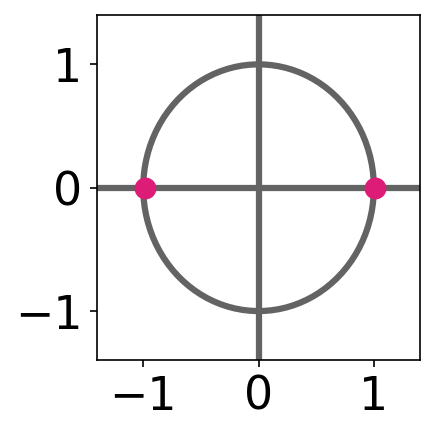

In [296]:
    #******************************************************************************
    # Eigenvalues
    #******************************************************************************
    model.eval()

    #if hasattr(model.dynamics, 'dynamics'):
    A =  model.dynamics.dynamics.weight.cpu().data.numpy()
    #A =  model.module.test.data.cpu().data.numpy()
    w, v = np.linalg.eig(A)
    print(np.abs(w))

    fig = plt.figure(figsize=(3, 3), facecolor="white",  edgecolor='k', dpi=150)
    plt.scatter(w.real, w.imag, c = '#dd1c77', marker = 'o', s=15*6, zorder=2, label='Eigenvalues')

    maxeig = 1.4
    plt.xlim([-maxeig, maxeig])
    plt.ylim([-maxeig, maxeig])
    plt.locator_params(axis='x',nbins=4)
    plt.locator_params(axis='y',nbins=4)

    #plt.xlabel('Real', fontsize=22)
    #plt.ylabel('Imaginary', fontsize=22)
    plt.tick_params(axis='y', labelsize=22)
    plt.tick_params(axis='x', labelsize=22)
    plt.axhline(y=0,color='#636363',ls='-', lw=3, zorder=1 )
    plt.axvline(x=0,color='#636363',ls='-', lw=3, zorder=1 )

    #plt.legend(loc="upper left", fontsize=16)
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), ls='-', lw=3, c = '#636363', zorder=1 )
    plt.tight_layout()
    plt.show()
    plt.close()

    plt.close('all')

## Reconstruction

In [364]:
with torch.no_grad():
    out, out_back = model(train_data[:][0], mode='forward')
reconstruction = out[-1]
print(reconstruction.shape)

torch.Size([2200, 1, 2, 1])


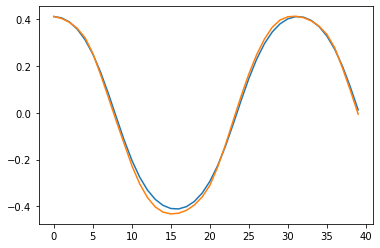

In [365]:
plt.figure()

plt.plot(Xclean_u[:,0][:40])
plt.plot(reconstruction[:,0,0,0][:40])
plt.show()